In [17]:
import argparse
import os
import random as rn

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context("paper", font_scale=1.3)
import pandas as pd
import numpy as np
import sys
import tensorflow as tf
import umap
from keras import backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import cv2

from sklearn import metrics
from sklearn import mixture
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from scipy.optimize import linear_sum_assignment as linear_assignment
from time import time
from keras.datasets import mnist
import umap.plot

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

%matplotlib inline

In [2]:
rn.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

In [3]:
np.set_printoptions(threshold=sys.maxsize)

matplotlib.use('agg')

In [4]:
def autoencoder(dims, act='relu'):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')
    h = x
    for i in range(n_stacks - 1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks - 1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
    h = Dense(dims[0], name='decoder_0')(h)

    return Model(inputs=x, outputs=h)

In [124]:
parser = argparse.ArgumentParser(
        description='(Not Too) Deep',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--n_clusters', default=50, type=int)
parser.add_argument('--batch_size', default=256, type=int)
parser.add_argument('--pretrain_epochs', default=50, type=int)
parser.add_argument('--ae_weights', default=None)
parser.add_argument('--save_dir', default='results/n2d')
parser.add_argument('--umap_dim', default=2, type=int)
parser.add_argument('--umap_neighbors', default=10, type=int)
parser.add_argument('--umap_min_dist', default="0.00", type=str)
parser.add_argument('--umap_metric', default='euclidean', type=str)
parser.add_argument('--cluster', default='GMM', type=str)
parser.add_argument('--eval_all', default=False, action='store_true')
parser.add_argument('--manifold_learner', default='UMAP', type=str)
parser.add_argument('--visualize', default=True, action='store_true')
args, unknown = parser.parse_known_args()
print(args)

Namespace(n_clusters=50, batch_size=256, pretrain_epochs=50, ae_weights=None, save_dir='results/n2d', umap_dim=2, umap_neighbors=10, umap_min_dist='0.00', umap_metric='euclidean', cluster='GMM', eval_all=False, manifold_learner='UMAP', visualize=True)


In [113]:
optimizer = 'adam'

In [114]:
path = os.getcwd()
train_data_dir = os.path.join(path, r'..\..\..\..\originals')

In [8]:
def load_dataset(path,size):
    count = 0
    image_data = []
    x_data = []
    train_folder_path = path                                                        # Folder Path
    for img in os.listdir(train_folder_path):                                       # This will iterate in the Folder
        if count < 50000:
            new_path = os.path.join(train_folder_path, img)                             # image Path
            image_data_temp = cv2.imread(new_path)                 # Read Image as numbers
            image_temp_resize = cv2.resize(image_data_temp,(size,size))
            image_data.append([image_temp_resize])
            #rn.shuffle(image_data)
            count = count + 1 
        else:
            break

    data = np.asanyarray(image_data)

    # Iterate over the Data
    for x in data:
        x_data.append(x[0])        # Get the X_Data

    X_Data = np.asarray(x_data) / (255.0)      # Normalize Data

    # reshape x_Data

    X_Data = X_Data.reshape(-1, size, size, 3)

    return X_Data

In [9]:
trainimages = load_dataset(train_data_dir,100)

In [1]:
# for i in range(50,60):
#     plt.imshow(trainimages[i])
#     plt.show()

In [11]:
x = trainimages
x = x.reshape((x.shape[0], -1))

In [34]:
x_test = np.array(test)
x_test = x_test.reshape((x_test.shape[0], -1))

In [12]:
shape = [x.shape[-1], 500, 500, 2000, args.n_clusters]
autoencoder = autoencoder(shape)

hidden = autoencoder.get_layer(name='encoder_%d' % (len(shape) - 2)).output
encoder = Model(inputs=autoencoder.input, outputs=hidden)

pretrain_time = time()

In [13]:
# Pretrain autoencoders before clustering
if args.ae_weights is None:
    autoencoder.compile(loss='mse', optimizer=optimizer)
    autoencoder.fit(
        x,
        x,
        batch_size=args.batch_size,
        epochs=args.pretrain_epochs,
        verbose=0)
    pretrain_time = time() - pretrain_time
    # autoencoder.save_weights('weights/' +
    #                          args.dataset +
    #                          "-" +
    #                          str(args.pretrain_epochs) +
    #                          '-ae_weights.h5')
    print("Time to train the autoencoder: " + str(pretrain_time))
else:
    autoencoder.load_weights('weights/' + args.ae_weights)


Time to train the autoencoder: 5677.498026609421


In [38]:
hl = encoder.predict(x)
# np.savetxt(args.save_dir + "/" + args.dataset + '-clusters.txt', clusters, fmt='%i', delimiter=',')

1563/1563 [==============================] - 50s 32ms/step


In [39]:
np.shape(hl)

(50000, 20)

In [51]:
md = float(args.umap_min_dist)
hle = umap.UMAP(random_state=0,
                metric=args.umap_metric,
                n_components=args.umap_dim,
                n_neighbors=args.umap_neighbors,
                min_dist=md).fit_transform(hl)

<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

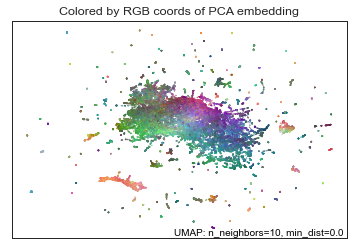

In [66]:
hle_test = umap.UMAP(random_state=0,
                metric=args.umap_metric,
                n_components=args.umap_dim,
                n_neighbors=args.umap_neighbors,
                min_dist=md).fit(hl)
# umap.plot.points(hle_test)
umap.plot.diagnostic(hle_test, diagnostic_type='pca')

In [125]:
km = KMeans(
    init='k-means++',
    n_clusters=args.n_clusters,
    random_state=0,
    n_init=20)

In [126]:
gmm = mixture.GaussianMixture(
    covariance_type='full',
    n_components=args.n_clusters,
    random_state=0)
gmm.fit(hle)

GaussianMixture(n_components=50, random_state=0)

In [127]:
y_pred_prob = gmm.predict_proba(hle)
#y_pred = km.fit_predict(hle)
y_pred = y_pred_prob.argmax(1)
y_pred = np.asarray(y_pred)
y_pred.max()

49

<AxesSubplot:xlabel='0', ylabel='1'>

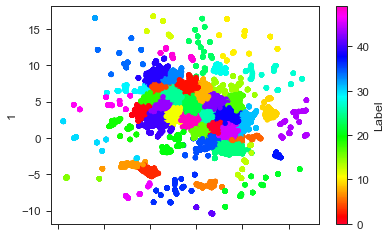

In [128]:
viz_df = pd.DataFrame(data=hle)
viz_df['Label'] = y_pred
viz_df.plot.scatter(x=0,y=1, c='Label', colormap='gist_rainbow')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


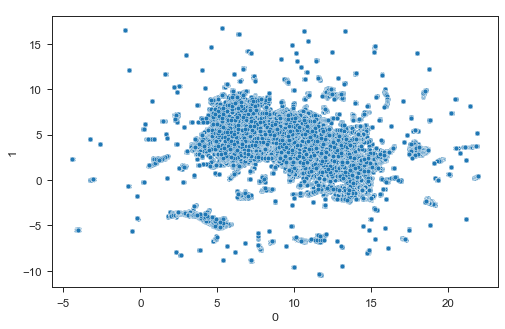

In [98]:
plt.subplots(figsize=(8, 5))
sns.scatterplot(x=0, y=1, legend='full', palette=sns.color_palette("hls", n_colors=50),data=viz_df)
l = plt.legend(bbox_to_anchor=(-.1, 1.00, 1.1, .5), loc="lower left", markerfirst=True,
               mode="expand", borderaxespad=0, ncol=args.n_clusters + 1, handletextpad=0.01, )

# l.texts[0].set_text("")
# plt.ylabel("")
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig('test.png', dpi=300)
# plt.clf()